In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
# visulaize the important characteristics of the dataset
import matplotlib.pyplot as plt
import os
import fnmatch
import librosa
# step 1: read the data

In [71]:
#get all files
path = r'C:\Users\gaoyu\Desktop\music try\data_resonance\resonance_set'
files = []
sound_labels =  np.array([])
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.wav'):
        files.append(os.path.join(root, filename))
        sound_labels=np.hstack((sound_labels, str(filename[:2])))  
print("found %d .wav files in %s"%(len(files),path))
print(sound_labels)
print(sound_labels.shape)

#get feature for a single audio file
#A.mfcc+delta(MFCC)+deltadelta(MFCC)-13(39)
def get_features(y, sr): 
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    log_S = librosa.amplitude_to_db(S, ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
    delta_mfcc = librosa.feature.delta(mfcc, mode='nearest')
    delta2_mfcc = librosa.feature.delta(mfcc, order=2, mode='nearest')
    feature_vector = np.concatenate((np.mean(mfcc,1), np.mean(delta_mfcc,1), np.mean(delta2_mfcc,1)))
    feature_vector = (feature_vector-np.mean(feature_vector)) / np.std(feature_vector)
    return feature_vector
#B.spectra(1025)
def get_features1(y, sr): 
    S = np.abs(librosa.stft(y))
    S=librosa.amplitude_to_db(S)
    feature_vector = np.mean(S,1)
    feature_vector = (feature_vector-np.mean(feature_vector)) / np.std(feature_vector)
    print(feature_vector.shape)
    return feature_vector
#C.harmonics
def get_features2(y, sr):
    a=librosa.effects.harmonic(y)
    feature_vector=a
    feature_vector = (feature_vector-np.mean(feature_vector)) / np.std(feature_vector)
    return feature_vector
    

# loop through all files to get the feature vector(x_std)
feature_vectors = np.array([])
for i,f in enumerate(files):
    y, sr = librosa.load(f, res_type="kaiser_fast")
    
    feat = get_features2(y, sr)
    if i==0:
        feature_vectors=np.hstack((feature_vectors, feat))
    else:
        try:
            feature_vectors=np.vstack((feature_vectors, feat))
        except:
            print(feat.shape)
            feat=feat[:4410]
            print(feat.shape)
            feature_vectors=np.vstack((feature_vectors, feat))

# (feature_dim,number of files)   
print(feature_vectors,feature_vectors.shape)

found 49 .wav files in C:\Users\gaoyu\Desktop\music try\data_resonance\resonance_set
['ba' 'ba' 'ba' 'ba' 'ba' 'ba' 'ba' 'ba' 'ba' 'ba' 'ba' 'ba' 'ba' 'fo'
 'fo' 'fo' 'fo' 'fo' 'fo' 'fo' 'fo' 'fo' 'fo' 'fo' 'fo' 'fo' 'fo' 'fo'
 'fo' 'fo' 'na' 'na' 'na' 'na' 'na' 'na' 'na' 'na' 'na' 'na' 'na' 'na'
 'na' 'na' 'na' 'na' 'no' 'no' 'no']
(49,)
(7254,)
(4410,)
[[-0.66689372 -0.69918436 -0.80782622 ...  0.15236062  0.15236062
   0.15236062]
 [ 0.87063587  0.70230728  0.58516973 ...  0.05021209  0.05021209
   0.05021209]
 [ 0.82424372  0.92535746  0.92112809 ...  0.04291914  0.04291914
   0.04291914]
 ...
 [ 0.08516765  0.03510728  0.03592548 ...  0.06062106  0.06062106
   0.06062106]
 [ 2.11155844  2.11864519  1.84817684 ...  0.0389136   0.0389136
   0.0389136 ]
 [ 0.5321601   0.42784649  0.23352766 ...  0.03171856  0.03171856
   0.03171856]] (49, 4410)


In [72]:
#get y(label array)---encode the class label
y=sound_labels
class_labels = np.unique(y)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
x=feature_vectors
standard_scaler = StandardScaler()
x_std = standard_scaler.fit_transform(x)

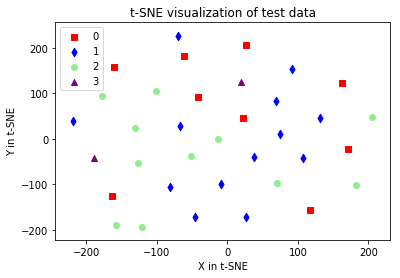

In [75]:
# plit the data into training set and test set
test_percentage = 0.7
x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size = test_percentage, random_state = 0)

# t-distributed Stochastic Neighbor Embedding (t-SNE) visualization
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
x_test_2d = tsne.fit_transform(x_test)

# scatter plot the sample points among 4 classes
markers=('s', 'd', 'o', '^')#, 'v'
# backward forward nasal no
color_map = {0:'red', 1:'blue', 2:'lightgreen', 3:'purple'}#,4:'cyan'
plt.figure()
for idx, cl in enumerate(np.unique(y_test)):
    plt.scatter(x=x_test_2d[y_test==cl,0], y=x_test_2d[y_test==cl,1], c=color_map[idx], marker=markers[idx], label=cl)
plt.xlabel('X in t-SNE')
plt.ylabel('Y in t-SNE')
plt.legend(loc='upper left')
plt.title('t-SNE visualization of test data')
plt.show()